In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

import tensorflow as tf
import keras

from keras.preprocessing.text import Tokenizer
import keras_preprocessing
from keras_preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import RNN, GRU, Input, Dense, Activation, RepeatVector, Bidirectional, LSTM, Dropout, Embedding
#from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split 
from keras.losses import sparse_categorical_crossentropy
from keras.preprocessing.text import Tokenizer
from keras_preprocessing import sequence
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import collections

from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\wuchu\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from tensorflow.python.keras.layers.embeddings import Embedding
from keras.losses import categorical_crossentropy

In [3]:
df = pd.read_csv('dataset/Text.csv')

In [4]:
df1 = pd.read_csv('preprocessed_lower_without_stopwords_stem_pos_tag.csv')
df2 = pd.read_csv('preprocessed_lower_without_stopwords_lemma_pos_tag.csv')
df3 = pd.read_csv('preprocessed_lower_with_stopwords_stem_pos_tag.csv')
df4 = pd.read_csv('preprocessed_lower_with_stopwords_lemma_pos_tag.csv')
df5 = pd.read_csv('preprocessed_lower_with_stopwords_pos_tag.csv')
df6 = pd.read_csv('preprocessed_lower_without_stopwords_pos_tag.csv')
df7 = pd.read_csv('preprocessed_without_lower_without_stopwords_pos_tag.csv')

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df['post_text'], df['label'], test_size=0.2, random_state = 123)

In [29]:
#define Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

#print size of the vocabulary
print(f'Train vocabulary size: {len(tok.word_index)}')

Train vocabulary size: 30204


In [30]:
#maximum sequence length (512 to prevent memory issues and speed up computation)
MAX_LEN = 40

#padded sequences
X_train_seq = sequence.pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = sequence.pad_sequences(test_sequences,maxlen=MAX_LEN)

In [31]:
model = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index)+1, 128),
    Bidirectional(tf.keras.layers.GRU(128,  return_sequences=True)),
    Bidirectional(tf.keras.layers.GRU(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#model.compile(optimizer=keras.optimizers.Adam(0.001),
#             loss='sparse_categorical_crossentropy',
#             metrics=['accuracy'])
#model.summary()


#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy'])

#model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_3 (ModuleWra  (None, 40, 128)          3866240   
 pper)                                                           
                                                                 
 bidirectional_6 (Bidirectio  (None, 40, 256)          198144    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               55680     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                      

In [32]:
history = model.fit(X_train_seq, y_train, epochs=5,validation_split = 0.2, batch_size = 16, callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

Epoch 1/5
796/796 [==============================] - 90s 105ms/step - loss: 0.3835 - accuracy: 0.8078 - val_loss: 0.2554 - val_accuracy: 0.8847
Epoch 2/5
796/796 [==============================] - 82s 103ms/step - loss: 0.0970 - accuracy: 0.9644 - val_loss: 0.2922 - val_accuracy: 0.9010
Epoch 3/5
796/796 [==============================] - 81s 102ms/step - loss: 0.0222 - accuracy: 0.9927 - val_loss: 0.3593 - val_accuracy: 0.8903
Epoch 4/5
796/796 [==============================] - 80s 100ms/step - loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.4553 - val_accuracy: 0.8894
Epoch 5/5
796/796 [==============================] - 80s 101ms/step - loss: 0.0045 - accuracy: 0.9978 - val_loss: 0.4758 - val_accuracy: 0.8683


In [33]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

125/125 [==============================] - 4s 28ms/step
Test Loss: 0.3161143660545349
Test Accuracy: 0.8951470851898193


In [34]:
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2024
           1       0.89      0.90      0.89      1953

    accuracy                           0.90      3977
   macro avg       0.90      0.90      0.90      3977
weighted avg       0.90      0.90      0.90      3977



Text(51.0, 0.5, 'Real Labels')

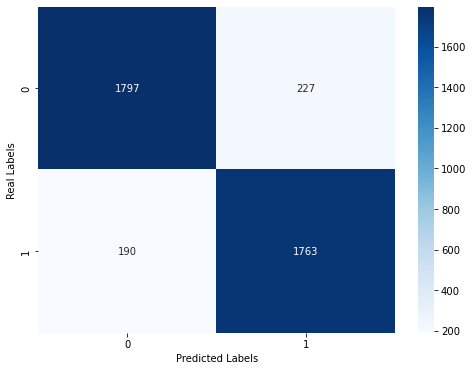

In [35]:
plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0)), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')